# Data Model : Classification Model using Titanic Data
#### Build CatBoost  Model to Predict the Survival of a Titanic Passenger

`CatBoost SkLearn API`

---

### Organization of the Notebook

Read Titanic Data

Split Data : Train, Validation, Test

Convert Data to `CatBoost Data Structure`

Build Model using `CatBoost API`

Model using Default Parameters

Predict

Performance Measure on Test Data

Plot Model Performance Metrics

`SHAP Analysis` for `Model Explainability`

Cross Validation

`Probability Calibration`

---

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing 
from sklearn import metrics 

In [3]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric, get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve

### Read Data

In [4]:
# import seaborn as sns
# train_df = sns.load_dataset('titanic')
# train_df = train_df.drop(['who','alive','alone'], axis=1)

In [5]:
# """CatBoost"""
#from catboost.datasets import titanic
#train_df, test_df = titanic()

In [6]:
# null_value_stats = train_df.isnull().sum(axis=0)
# null_value_stats[null_value_stats != 0]
# train_df.fillna(-9999, inplace=True)
# test_df.fillna(-9999, inplace=True)

In [7]:
# X = train_df.drop('Survived', axis=1)
# y = train_df.Survived

In [8]:
"""Import Jupyter Notebook"""

import ipynb
import ipynb.fs.full.example_titanicData_dataProcessing as jnds

train_df, test_df = jnds.train_test_ordinal
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

#### Split Data

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
"""Setting the Seed"""
theSeed = 209

In [11]:
categorical_features_indices = np.where(X.dtypes != np.float64)[0]

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.80, random_state=theSeed)
print(f'train data: {X_train.shape}')
print(f'valid data: {X_valid.shape}')

train data: (785, 16)
valid data: (197, 16)


In [13]:
#X_test = test_df
X_test = test_df.drop(['Survived'], axis=1)
y_test = test_df.Survived
print(f'test data : {X_test.shape}')

test data : (327, 16)


#### Setting Weight to the Data

In [14]:
# class_weights = [1.85, 2.17]
# scale_pos_weight = np.random.rand(X_train.shape[0], )
# weight = np.random.rand(X_train.shape[0], )

#### CatBoost Data Structure 

In [15]:
# train_data = Pool(X_train, label=y_train, cat_features=categorical_features_indices, weight=None)
# valid_data = Pool(X_valid, label=y_valid, cat_features=categorical_features_indices, weight=None)
# test_data  = Pool(X_test, label=y_test, cat_features=categorical_features_indices, weight=None)

In [16]:
train_data = Pool(X_train, label=y_train, weight=None)
valid_data = Pool(X_valid, label=y_valid, weight=None)
test_data  = Pool(X_test, label=y_test, weight=None)

### Train Model

#### Model with Default Parameters

In [17]:
model = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss=['Accuracy','Logloss','F1'],
    eval_metric='AUC', 
    iterations=100,
    learning_rate=0.03, 
    l2_leaf_reg=3.0, 
    logging_level='Silent',
    early_stopping_rounds=None,
    model_shrink_mode=None,
    use_best_model=False,
    random_seed=theSeed
)

In [18]:
fit = model.fit(
    X_train, y_train,
    #cat_features=categorical_features_indices,
    eval_set=[(X_valid, y_valid)],
    plot=False
)

#### Model Evaluation

In [19]:
from catboost import utils

In [20]:
# utils.eval_metrics(valid_data,
#              'AUC',
#              ntree_start=0,
#              ntree_end=0,
#              eval_period=1,
#              thread_count=-1)

In [21]:
train_eval      = fit.eval_metrics(train_data, ['AUC'], plot=False)
valid_eval_auc  = fit.eval_metrics(valid_data, ['AUC'], plot=False)
valid_eval_loss = fit.eval_metrics(valid_data, ['Logloss'], plot=False)
valid_eval_f1   = fit.eval_metrics(valid_data, ['F1'], plot=False)

In [22]:
tn, fp, fn, tp = utils.get_confusion_matrix(model, valid_data).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:112.0, FP:1.0, FN:6.0, TP:78.0


In [23]:
thresholds, fpr = utils.get_fpr_curve(model, valid_data, plot=False)
thresholds, fnr = utils.get_fnr_curve(model, valid_data, plot=False)

In [24]:
fpr, tpr, thresholds = utils.get_roc_curve(model, valid_data, plot=False)

In [25]:
meanAUC = np.mean( np.array(valid_eval_auc['AUC']) )
stdvAUC = np.std( np.array(valid_eval_auc['AUC']) )
print(f"Mean & Std of AUC : { round(meanAUC,4),  round(stdvAUC,4)}")

Mean & Std of AUC : (0.9835, 0.0051)


In [26]:
utils.get_confusion_matrix(fit, valid_data)

array([[112.,   1.],
       [  6.,  78.]])

In [27]:
feature_importances = model.get_feature_importance(train_data)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print(f"{name}  : {round(score,2)}" )

Boat  : 87.02
Sex  : 4.53
Embarked  : 0.98
NameLength  : 0.92
Ticket  : 0.77
Title  : 0.73
LastName  : 0.64
Pclass  : 0.63
Fare  : 0.59
Cabin  : 0.54
HomeDest  : 0.54
Parch  : 0.5
FamilySize  : 0.45
Name  : 0.39
SibSp  : 0.38
Age  : 0.38


In [28]:
auc = valid_eval_auc['AUC']
auc = np.array(auc)
print(f"Mean AUC  : { round(auc.mean(),4)}")
loss = valid_eval_loss['Logloss']
loss = np.array(loss)
print(f"Mean Loss : { round(loss.mean(),4)}")

Mean AUC  : 0.9835
Mean Loss : 0.2937


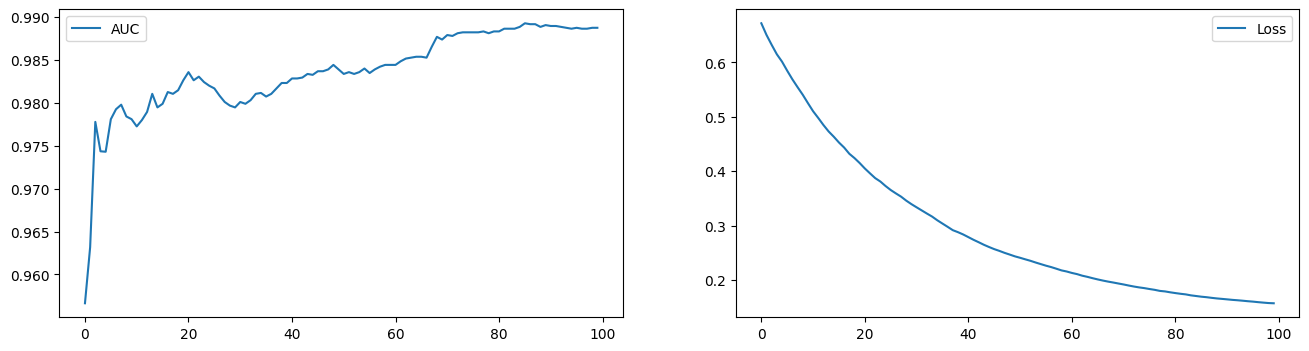

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
ax[0].plot(auc, label='AUC')
ax[1].plot(loss,label='Loss')

ax[0].legend()
ax[1].legend()
plt.show()

In [30]:
# features = 2
# model.plot_partial_dependence(train_data, features)

# model.plot_predictions(train_data, features_to_change=[1,2,3])
# model.plot_tree(tree_idx=0, pool=train_data)

### Predict

In [31]:
y_pred  = model.predict(
        X_test,
        prediction_type='Class',
        ntree_start=0, 
        ntree_end=0, 
        thread_count=-1, 
        verbose=False)

y_score  = model.predict(
        X_test,
        prediction_type='Probability',
        ntree_start=0, 
        ntree_end=0, 
        thread_count=-1, 
        verbose=False)

# Score can also be Obtained using predict_proba
#y_score = model.predict_proba(X_test)

### Performance Metrics on Test Data

In [32]:
from sklearn import metrics

In [33]:
"""Accuracy Score"""
accuracy = metrics.accuracy_score(y_test, y_pred, sample_weight=None, normalize=True)
print( round(accuracy, 4))

0.9786


In [34]:
"""Balanced Accuracy Score"""
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred, sample_weight=None, adjusted=False)
print( round(balanced_accuracy, 4))

0.9743


In [35]:
"""ROC Curve"""
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])

In [36]:
"""AUC"""
auc = metrics.auc(fpr, tpr)
print( round(auc, 4))

0.9959


In [37]:
"""Confusion Matrix"""
metrics.confusion_matrix(y_test, y_pred)

array([[205,   2],
       [  5, 115]])

In [38]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:205, FP:2, FN:5, TP:115


In [39]:
"""F1 Score"""
f1 = metrics.f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
print( round(f1, 4))

0.9705


In [40]:
"""Log Loss"""
metrics.log_loss(y_test, y_score[:, 1], normalize=True, sample_weight=None, labels=[0,1])

0.12584698558852211

In [41]:
"""Precision, Recall, Fscore, Support"""
metrics.precision_recall_fscore_support(y_test, y_pred, labels=[0,1], pos_label=1, 
                                        average=None, sample_weight=None)

(array([0.97619048, 0.98290598]),
 array([0.99033816, 0.95833333]),
 array([0.98321343, 0.97046414]),
 array([207, 120]))

In [42]:
precision = metrics.precision_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                                    average='binary', sample_weight=None)
print( round(precision, 4))

0.9829


In [43]:
recall = metrics.recall_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                              average='binary', sample_weight=None)
print( round(recall, 4))

0.9583


### Performance Metric Plots

Confusion Matrix

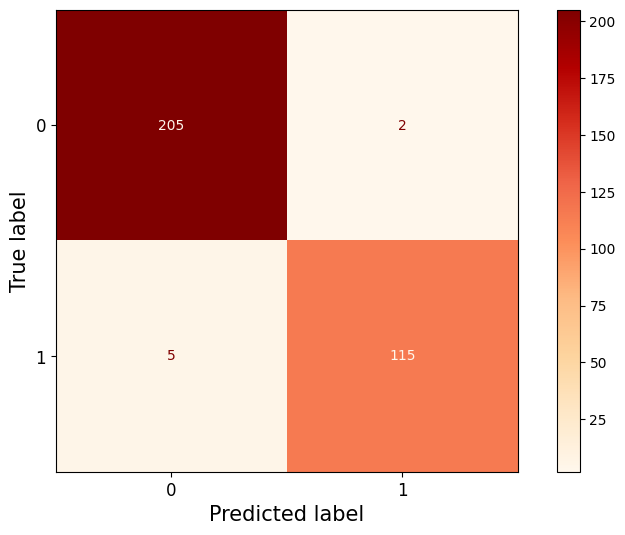

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,6))


ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels([0,1], fontsize=12)
ax.set_yticklabels([0,1], fontsize=12)

ax.set_xlabel("", fontsize=15)
ax.set_ylabel("", fontsize=15)

ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, 
    labels=None, 
    sample_weight=None, 
    normalize=None, 
    display_labels=[0,1], 
    cmap='OrRd', 
    #color='w',
    ax=ax
)

plt.show()

ROC Curve

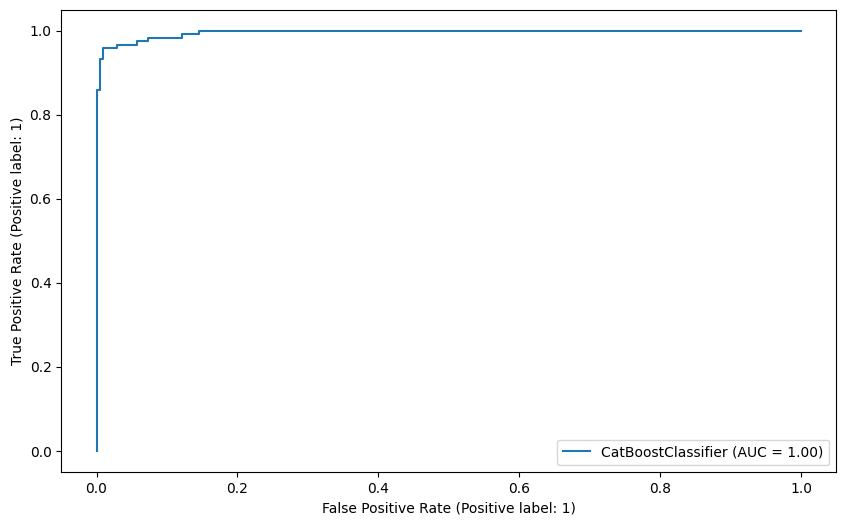

In [45]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10,6))

RocCurveDisplay.from_estimator(model, X_test, y_test, sample_weight=None, ax=ax)

plt.show()

PR Curve

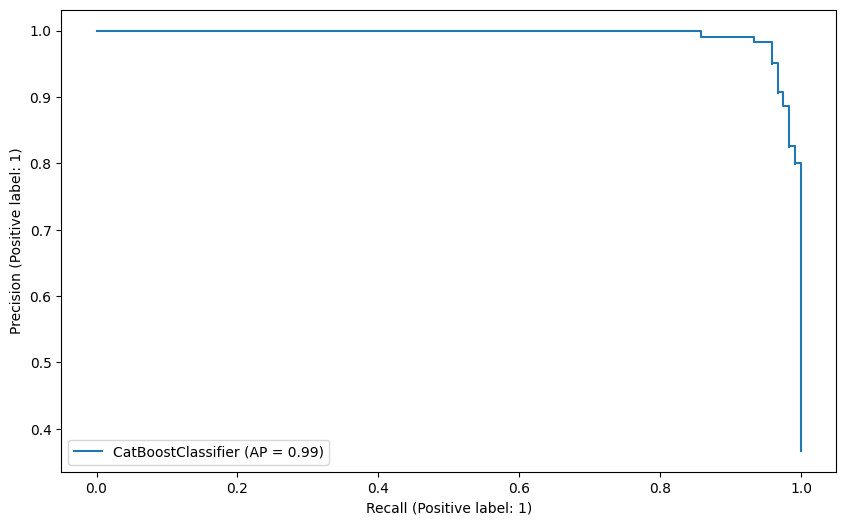

In [46]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(10,6))

PrecisionRecallDisplay.from_estimator(model, X_test, y_test, sample_weight=None, ax=ax)

plt.show()

### SHAP Analysis

In [47]:
import shap
shap.initjs()

In [48]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

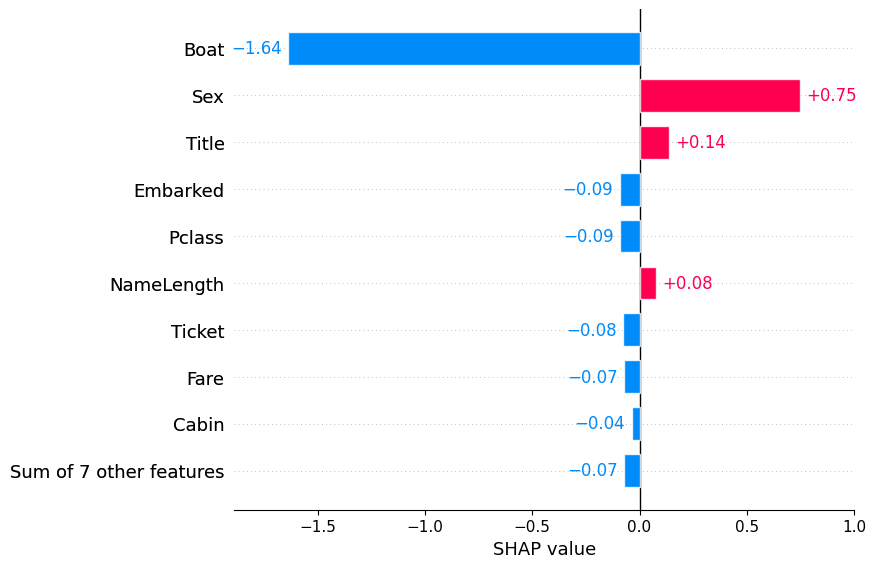

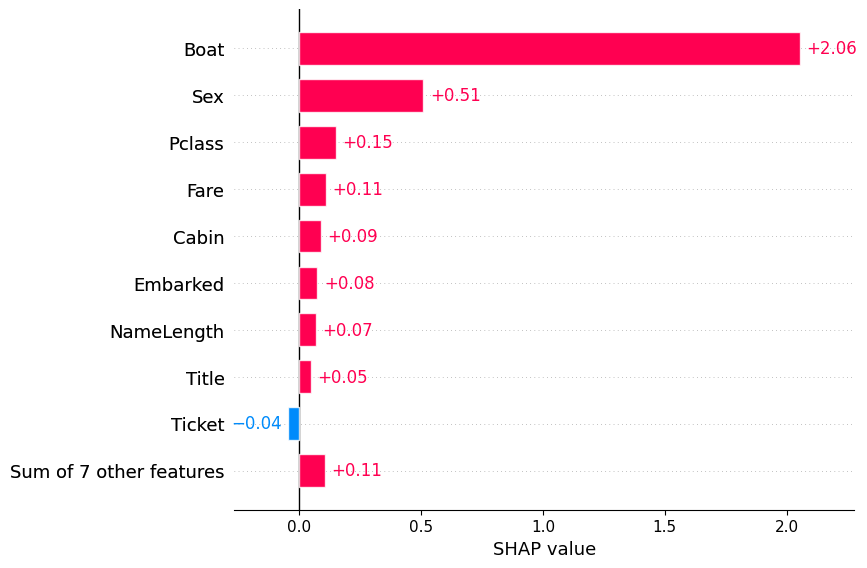

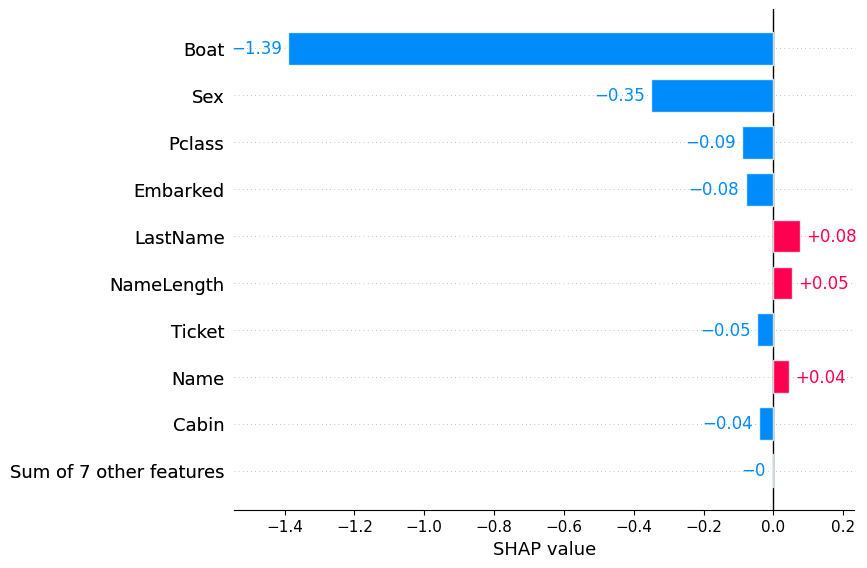

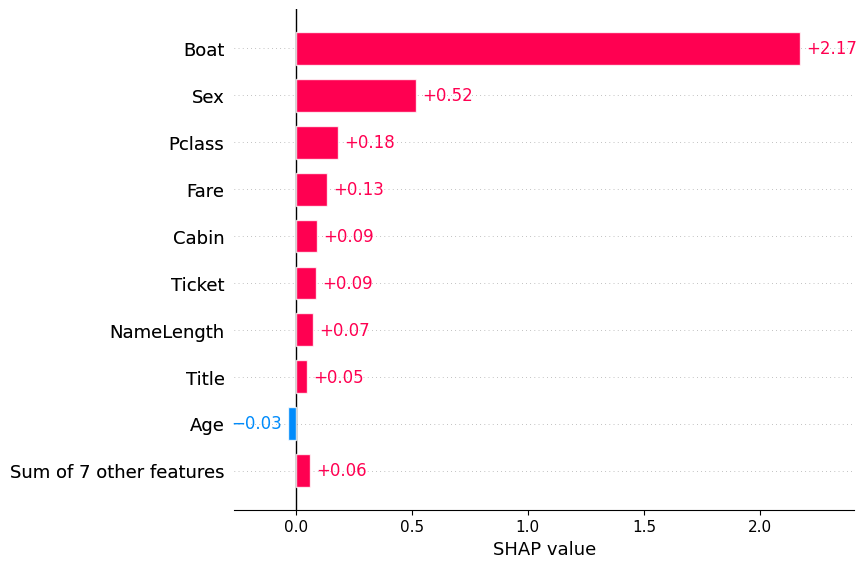

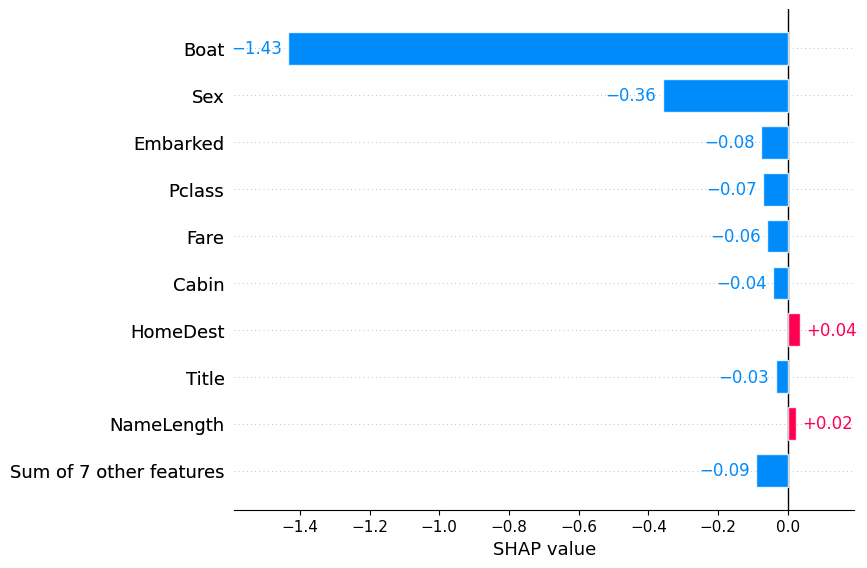

In [49]:
for i in range(5):
    shap.plots.bar(shap_values[i])

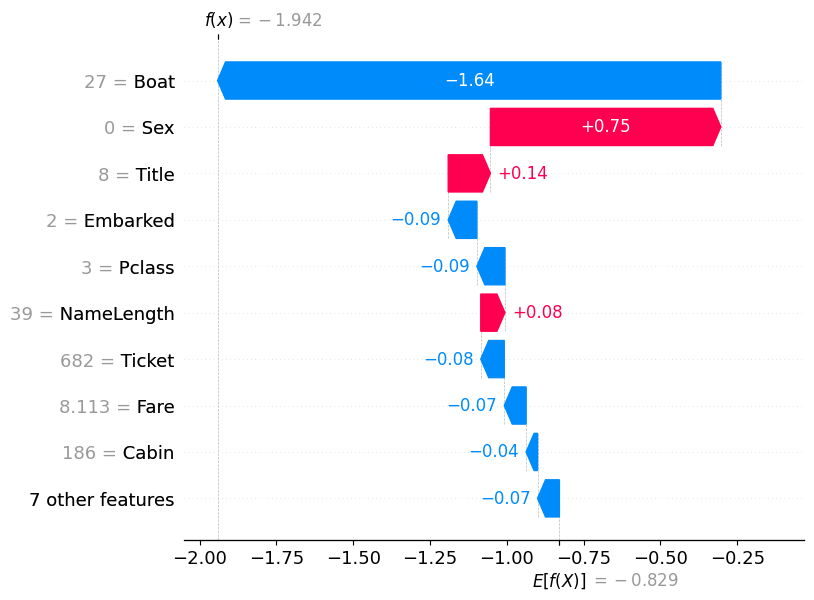

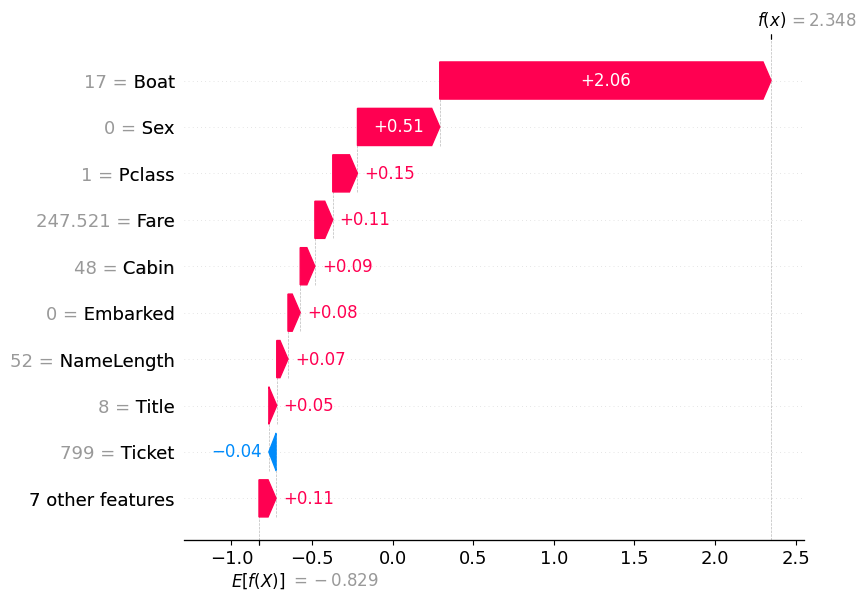

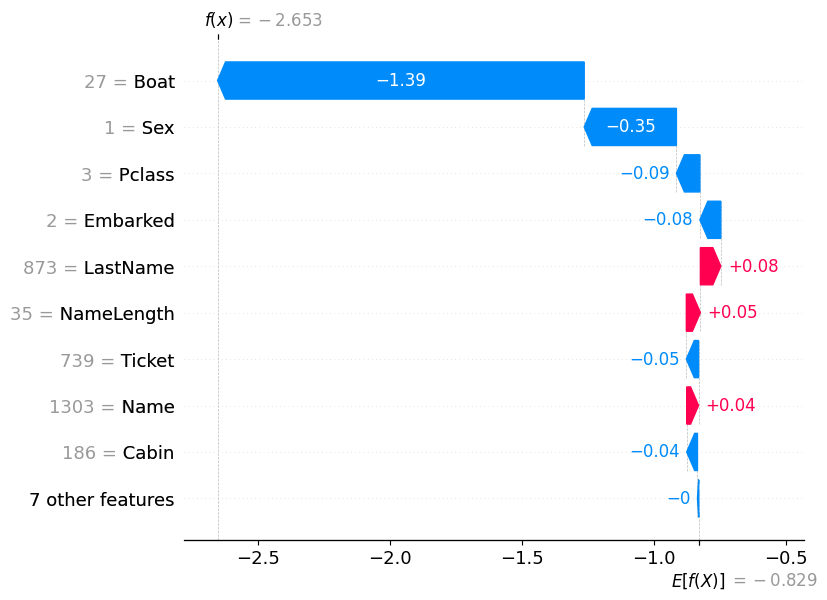

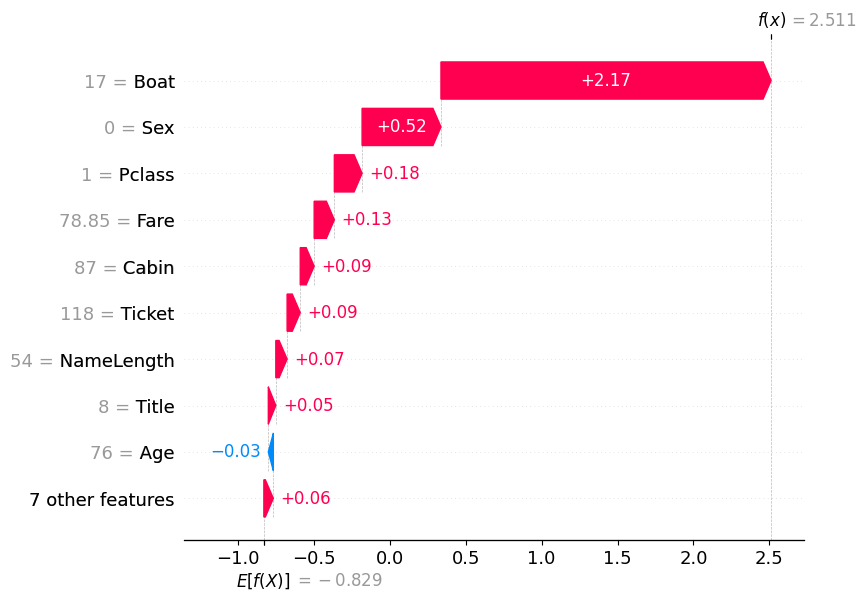

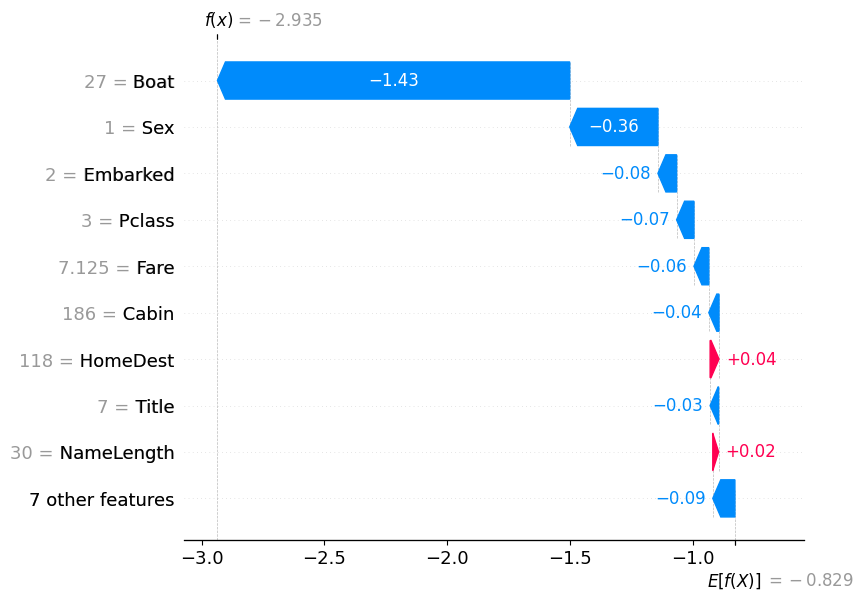

In [50]:
for i in range(5):
    shap.plots.waterfall(shap_values[i])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


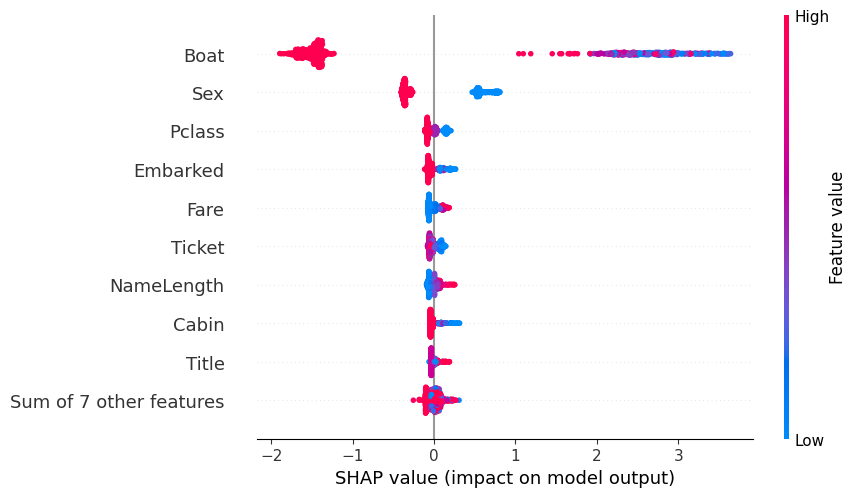

In [51]:
shap.plots.beeswarm(shap_values)

In [52]:
treeExplainer = shap.TreeExplainer(
    model, 
    data=None, 
    feature_perturbation= "tree_path_dependent", 
    model_output='raw')
shap_values = treeExplainer.shap_values(X_train)

Visualize the first prediction's explanation

In [53]:
shap.force_plot(treeExplainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Visualize the Training set Predictions

In [54]:
shap.force_plot(treeExplainer.expected_value, shap_values, X_train)

#### SHAP Summary Plot

Summarize the effects of all the features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


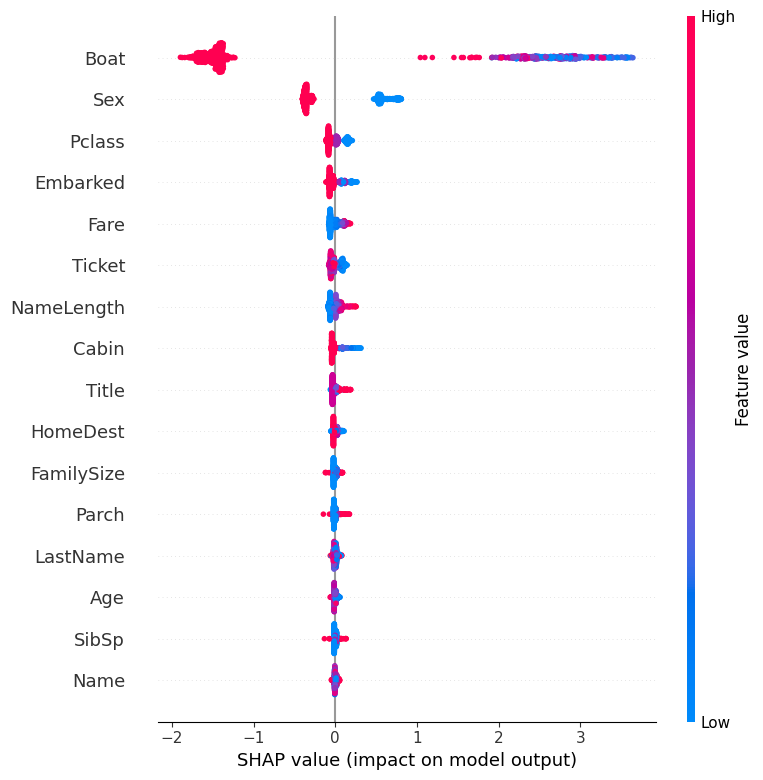

In [55]:
shap.summary_plot(shap_values, X_train)

####  SHAP Dependence Plot

Create a SHAP dependence plot to show the effect of a single feature across the whole dataset

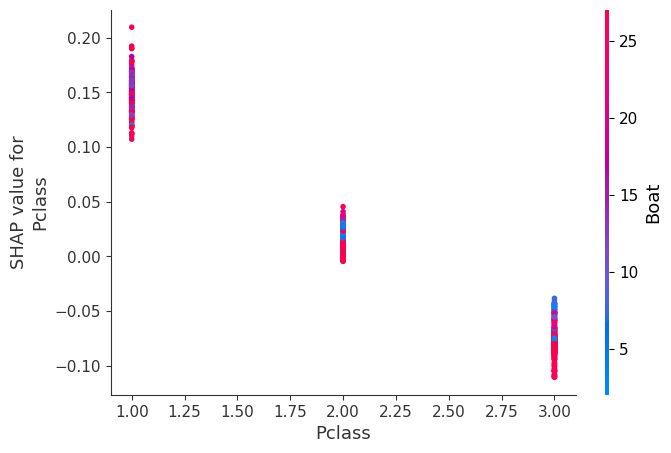

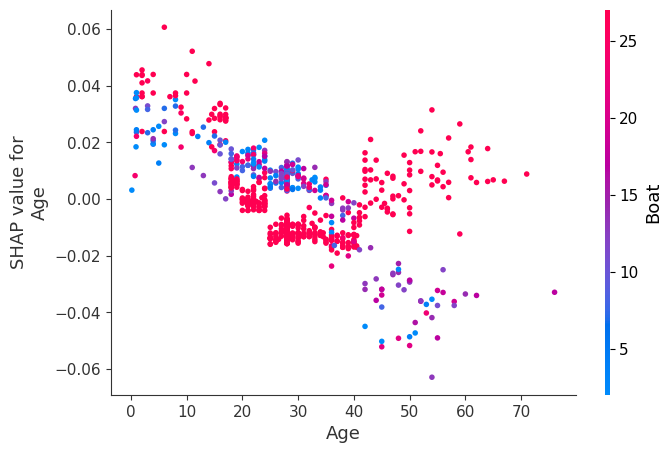

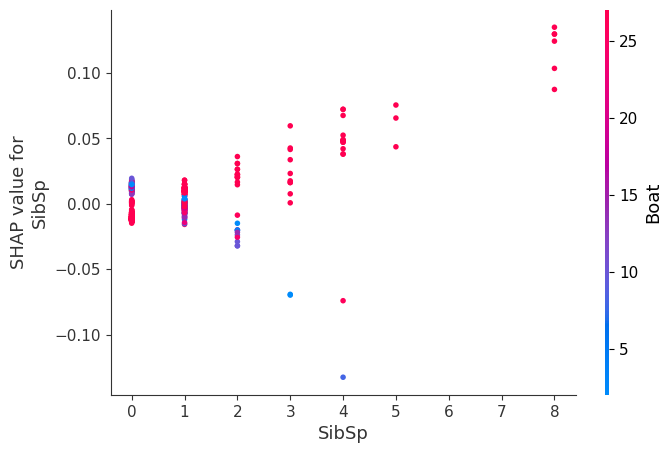

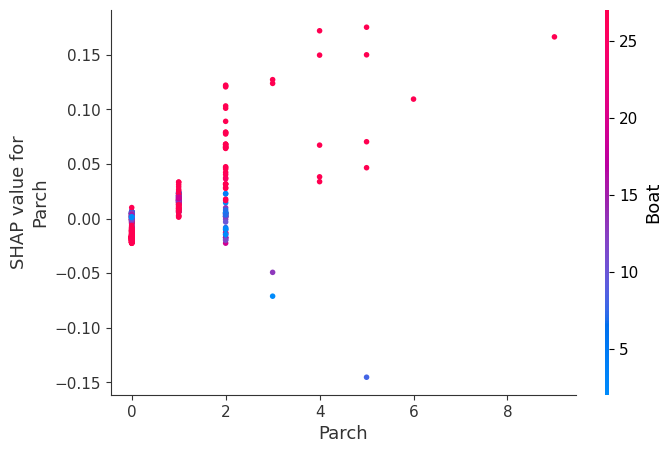

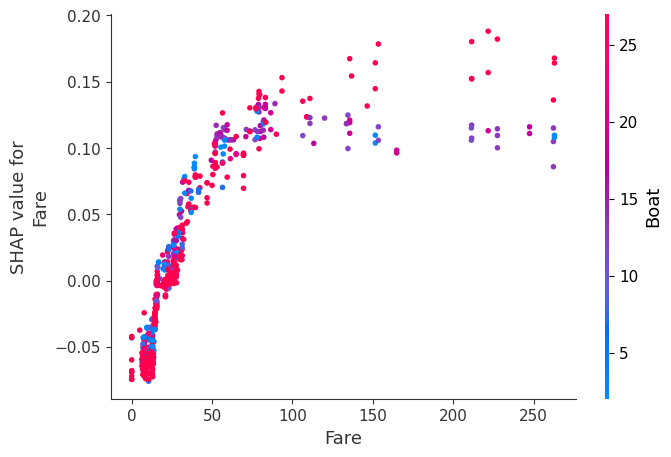

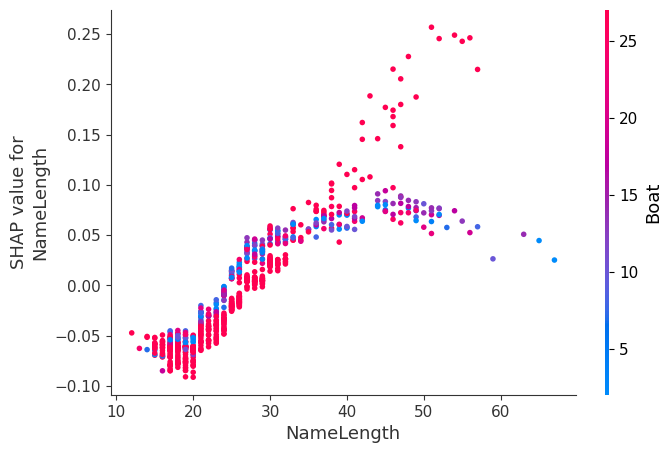

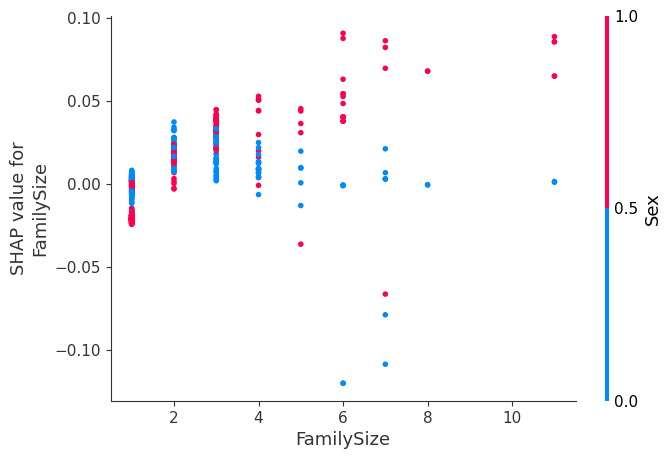

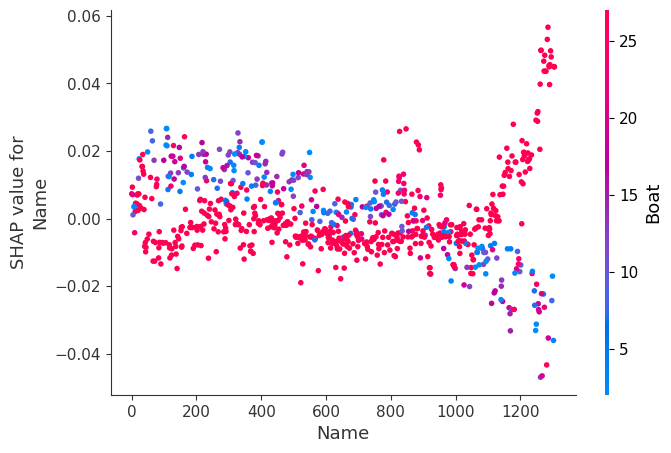

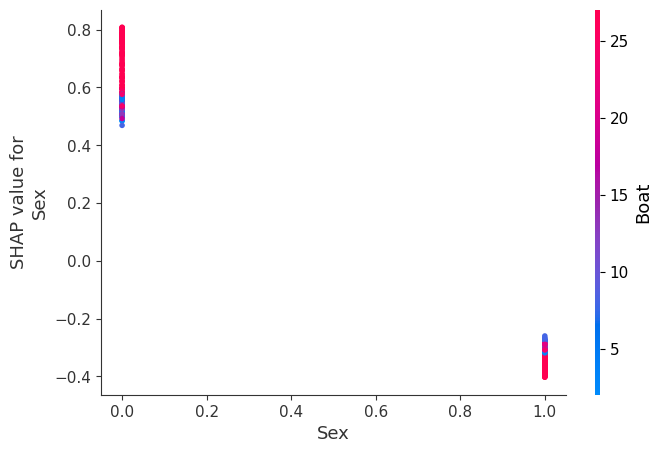

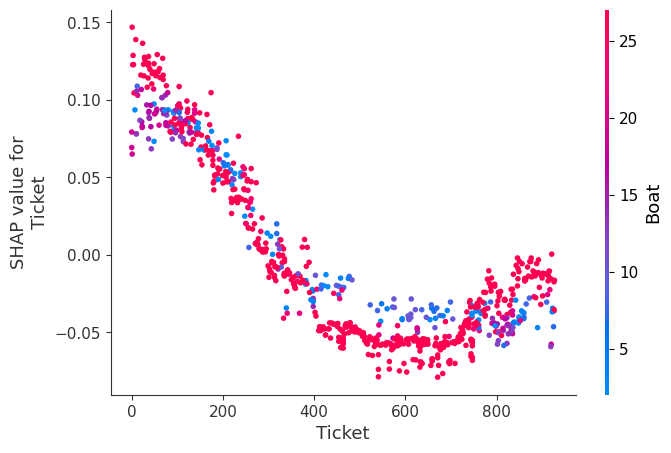

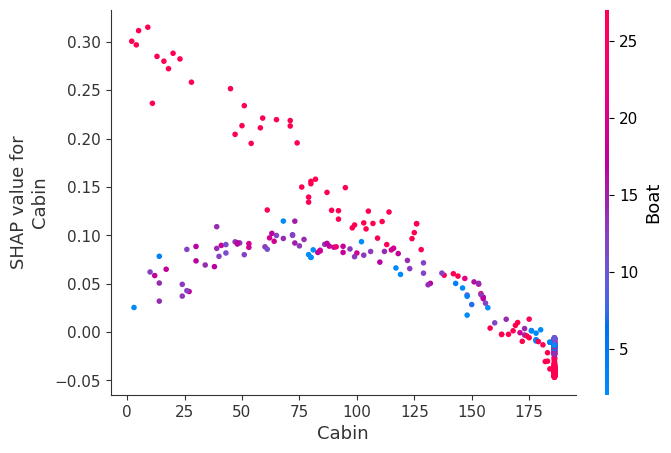

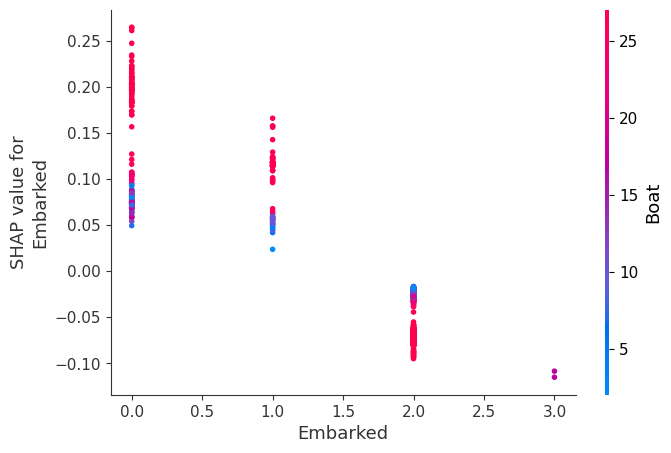

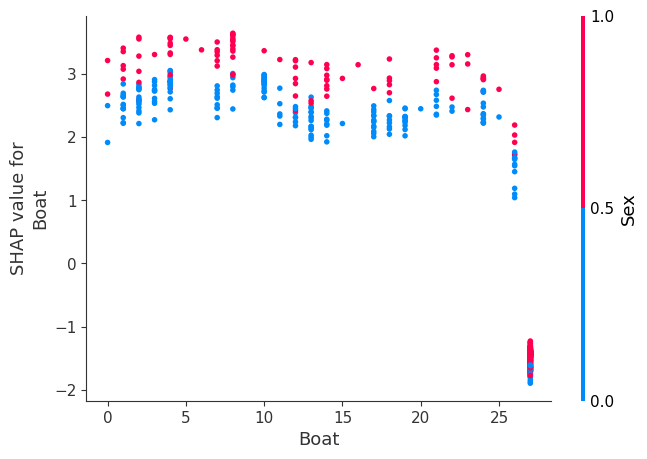

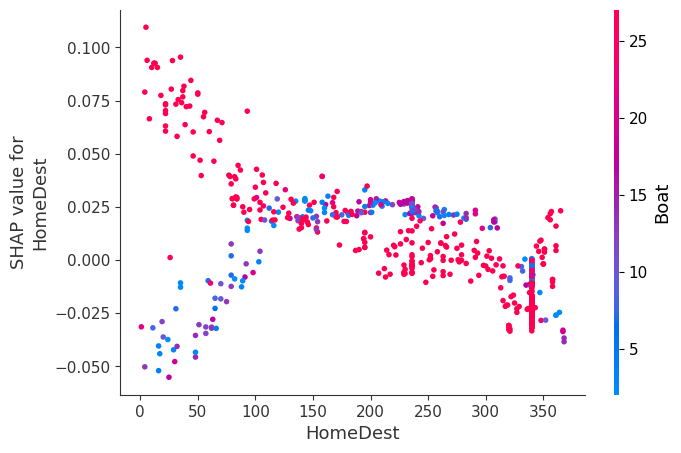

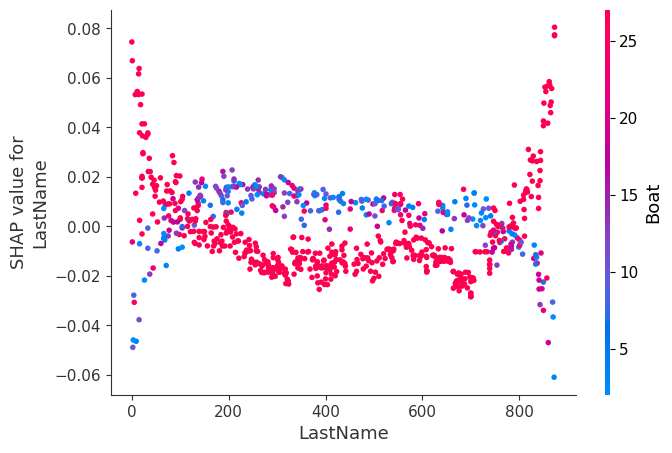

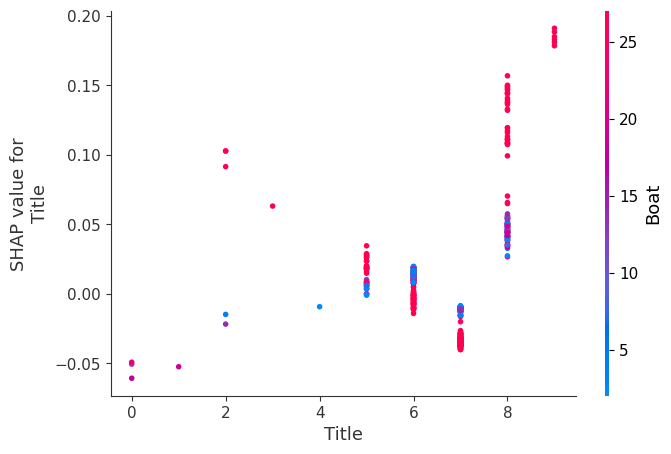

In [56]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

### Cross-Validation

In [57]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

#### Model with Default Parameters

In [58]:
cvmodel = CatBoostClassifier(
    loss_function='Logloss',
    #custom_loss=['Accuracy','Logloss','F1'],
    eval_metric='AUC', 
    iterations=100,
    learning_rate=0.03, 
    l2_leaf_reg=3.0, 
    #cat_features=categorical_features_indices,
    logging_level='Silent',
    early_stopping_rounds=None,
    model_shrink_mode=None,
    random_seed=theSeed
)

In [59]:
y_pred = cross_val_predict(cvmodel, X_train, y_train, cv=5)

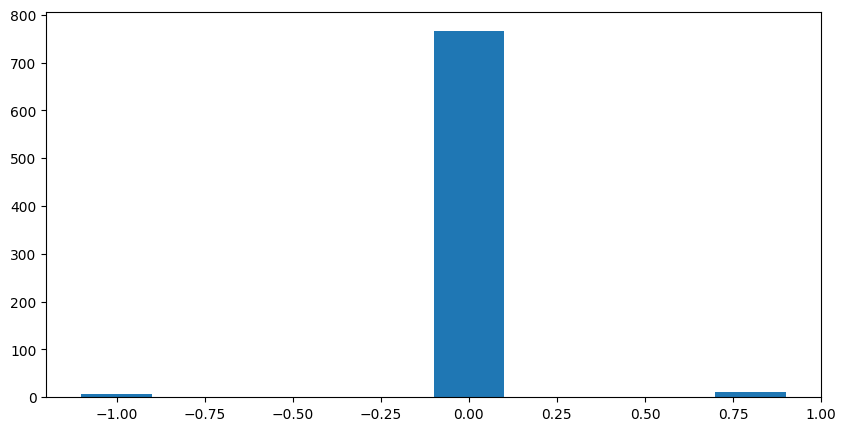

[0.00764331 0.         0.         0.         0.         0.97707006
 0.         0.         0.         0.01528662]


In [60]:
fig, ax = plt.subplots( figsize=(10,5) )

y_delta = y_train.to_numpy() - y_pred
n, bins, patches = ax.hist(y_delta, density=False, histtype='bar', rwidth=2.5, align='left', stacked=False)

plt.show()

print( n/len(y_pred) )

In [61]:
scores = cross_val_score(cvmodel, X_train, y_train, scoring='accuracy', cv=5)
scores

array([0.98089172, 0.96815287, 0.97452229, 0.98726115, 0.97452229])

In [62]:
scores = cross_validate(cvmodel, X_train, y_train, scoring=['accuracy','roc_auc','f1'], cv=5)
scores

{'fit_time': array([0.12334681, 0.11771989, 0.12574792, 0.12306786, 0.124506  ]),
 'score_time': array([0.00479412, 0.00543594, 0.00539708, 0.00507116, 0.0060091 ]),
 'test_accuracy': array([0.98089172, 0.96815287, 0.97452229, 0.98726115, 0.97452229]),
 'test_roc_auc': array([0.99429263, 0.97423037, 0.98616396, 0.99342788, 0.99639175]),
 'test_f1': array([0.97435897, 0.95575221, 0.96610169, 0.98333333, 0.96610169])}

### Probability Calibration

In [63]:
from sklearn.calibration import CalibratedClassifierCV

In [64]:
calibrated_model = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')

In [65]:
calibrated_fit = calibrated_model.fit(X_test, y_test)

In [66]:
calibrated_y_pred  = calibrated_fit.predict(X_test)
calibrated_y_score = calibrated_fit.predict_proba(X_test)

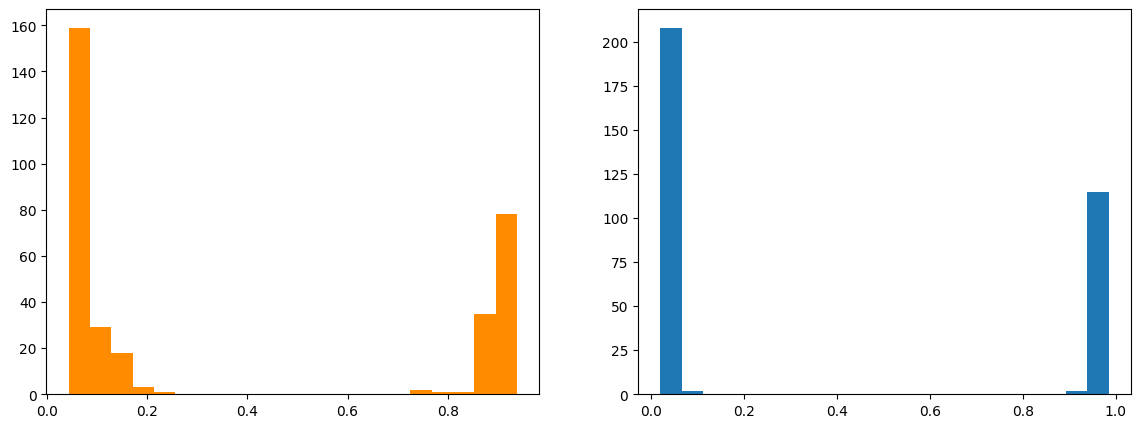

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
ax[0].hist(y_score[:,1], bins=21, color='darkorange')
ax[1].hist(calibrated_y_score[:,1], bins=21)
plt.show()